In [3]:
import numpy as np

In [4]:
import ase
import os
import numpy as np
import matplotlib.pyplot as plt

from ase import io
from ase.geometry.analysis import Analysis
from ase import build
from ase.neighborlist import neighbor_list

os.chdir('/Users/Moji/Documents/Summer20/Ge')

In [5]:
amo = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.' + str(i)
                         + '.cfg')) for i in range(220000, 240000, 1000)]
hiT_amo = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.' + str(i)
                                  + '.cfg')) for i in range(180000, 220000, 1000)]
inter = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.' + str(i)
                                  + '.cfg')) for i in range(140000, 180000, 1000)]
liquid = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.'
                            + str(i) + '.cfg')) for i in range(60000, 140000, 1000)]
hiT_liq = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.'
                            + str(i) + '.cfg')) for i in range(20000, 60000, 1000)]

In [6]:
MD = [amo, hiT_amo, inter, liquid, hiT_liq]

In [ ]:
dia = ase.Atoms(build.bulk('Ge', crystalstructure='diamond', cubic=True))
dia_s = build.make_supercell(dia, [[2, 0, 0],
                                  [0, 2, 0],
                                  [0, 0, 2]])

liq_ana = Analysis(liquid)
amo_ana = Analysis(amo)
dia_ana = Analysis(dia_s)
liq_3b_ana = Analysis(liquid_3b)

liq_rdf = np.average(liq_ana.get_rdf(4.9, 400), axis=0)
amo_rdf = np.average(amo_ana.get_rdf(4.9, 400), axis=0)
dia_rdf = np.average(dia_ana.get_rdf(4.9, 400), axis=0)
liq_3b_rdf = np.average(liq_3b_ana.get_rdf(4.9, 400), axis=0)

liq_n = [neighbor_list('i', i, cutoff=3.0) for i in liquid]
liq_n = [neighbor_list('i', i, cutoff=3.0) for i in liquid_3b]
amo_n = [neighbor_list('i', i, cutoff=3.0) for i in amo]
dia_n = neighbor_list('i', dia_s, cutoff=3.0)


np.average([np.bincount(i) for i in amo_n], axis=0)

np.average([np.bincount(i) for i in liq_n], axis=0)

dists = np.linspace(0, 4.9, 400)
fig, axs = plt.subplots(figsize=(10,10))
axs.scatter(dists, liq_rdf)
axs.scatter(dists, amo_rdf)
axs.scatter(dists, liq_3b_rdf)
#axs.scatter(dists, dia_rdf)
plt.show()

In [19]:
from sys import path
path.append('/Users/Moji/Applications/QUIP/build/darwin_x86_64_gfortran')
from ase import Atoms
from ase.io import write, read
import re
from quippy.potential import Potential

data_dir = '/Users/Moji/Documents/Summer20/Ge/'
gap = Potential(param_filename= data_dir + 'Potentials/Ge_2bSOAP_5000_125_216_condepreg/Ge_2bSOAP_5000_125_216_condepreg.xml')
train_file = data_dir + 'Structure_databases/train_216_125_64_v.xyz'
val_file = data_dir + 'Structure_databases/validate_216_125_64_v.xyz'
T_ct = 0
V_ct = 0
with open(train_file) as f:
    for i in f.readlines():
        if re.match("^[1-9]+$", i):
            T_ct += 1
print('Training set structure count:', T_ct)
with open(val_file) as f:
    for i in f.readlines():
        if re.match("^[1-9]+$", i):
            V_ct += 1
print('Validation set structure count:', V_ct)
zero_e = read(train_file, format='extxyz', index=0).info['dft_energy']
T_set = [read(train_file, format='extxyz', index=i) for i in range(1, T_ct)]
V_set = [read(val_file, format='extxyz', index=i) for i in range(1, V_ct)]
config_labels = []
for i in T_set:
    if not i.info['config_type'] in config_labels:
        config_labels.append(i.info['config_type'])
print('Config labels:', config_labels)
T_configs = [[i for i in T_set if i.info['config_type'] == j] for j in config_labels]
V_configs = [[i for i in V_set if i.info['config_type'] == j] for j in config_labels]

def calc_gap_observables(data_base, gap):
    '''Calculates GAP forces and energies by config_type'''
    E = [[] for i in data_base]
    F = [[] for i in data_base]
    for i, val in enumerate(data_base):
        for dba in val:
            a = dba.copy()
            a.set_calculator(gap)
            E[i].append(a.get_total_energy()/len(a))
            F[i].extend(a.get_forces().flatten())
    return E, F

flatten = lambda l: [item for sublist in l for item in sublist]

T_qm_energies = [[at.info['dft_energy']/len(at) for at in j] for j in T_configs]
V_qm_energies = [[at.info['dft_energy']/len(at) for at in j] for j in V_configs]
T_qm_forces = [[i for at in j for i in at.get_array('dft_forces').flatten()] for j in T_configs]
V_qm_forces = [[i for at in j for i in at.get_array('dft_forces').flatten()] for j in V_configs]

Training set structure count: 281
Validation set structure count: 70
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']


In [ ]:
import pickle
infile = open('/Users/Moji/Documents/Summer20/Ge/Pickles/data_2bSOAP5000_5c_125_216_cdr', 'rb')
data_cdr = pickle.load(infile)
T_gap_energies = data_cdr[0][3]
T_gap_forces = data_cdr[0][4]

In [ ]:
T_csize_dat = [[i for i in T_set if i.get_global_number_of_atoms() == 64],
               [i for i in T_set if i.get_global_number_of_atoms() == 125],
                [i for i in T_set if i.get_global_number_of_atoms() == 216]]
T_qm_e_cs = [[at.info['dft_energy']/len(at) - zero_e for at in j] for j in T_csize_dat]
T_qm_f_cs = [[i for at in j for i in at.get_array('dft_forces').flatten()] for j in T_csize_dat]

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
axs.hist(T_qm_e_cs, bins=50, stacked=True, label=['64','125','216'])
plt.legend()
plt.show()

In [9]:
def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms. Shapes: {0}, {1}'
                         .format(np.shape(x_ref), np.shape(x_pred)))

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

In [10]:
def sort_by_timestep(d):
    return sorted(d, key=lambda x: labels[d.index(x)], reverse=True)


labels = [240, 120, 20, 180, 160]
T_configs_s = sort_by_timestep(T_configs)
T_qm_energies_s = sort_by_timestep(T_qm_energies)
T_qm_forces_s = sort_by_timestep(T_qm_forces)
T_gap_energies_s = sort_by_timestep(T_gap_energies)
T_gap_forces_s = sort_by_timestep(T_gap_forces)
lab_sort = sorted(labels, reverse=True)
print(lab_sort)

NameError: name 'T_gap_energies' is not defined

In [50]:
ans2 = [[Analysis(j) for j in i] for i in T_configs_s]
ans = [[Analysis(j) for j in i] for i in MD]
rdf = [np.average(np.array([i.get_rdf(4.9, 400) for i in j]), axis=0) for j in ans]
rdf2 = [np.average(np.array([i.get_rdf(4.9, 400) for i in j]), axis=0) for j in ans2]
dists = np.linspace(0, 4.9, 400)

<ipython-input-58-b233ecb9a463>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


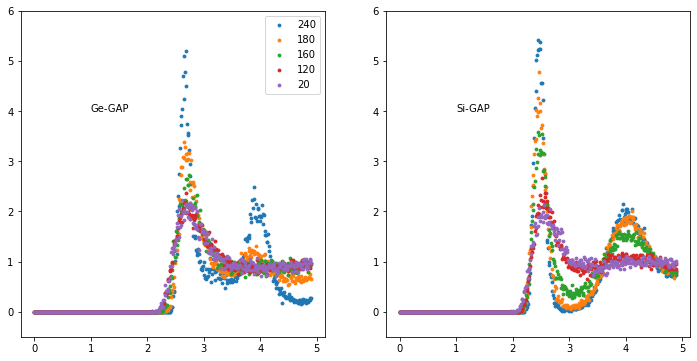

In [58]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for i in range(len(rdf)):
    axs[0].scatter(dists, rdf[i], label=lab_sort[i], s=8)
    axs[1].scatter(dists, rdf2[i], label=lab_sort[i], s=8)

axs[0].set(ylim=(-0.5,6))
axs[1].set(ylim=(-0.5,6))
axs[0].text(1,4,'Ge-GAP')
axs[1].text(1,4,'Si-GAP')
axs[0].legend()
fig.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/Si-Ge-GAP_rdfs.png')

In [ ]:
lab_sort_rmse = ['{0:>4d}      {1:>5.2f}      {2:>5.3f}'.format(lab_sort[i],
                  rms_dict(T_qm_energies_s[i],T_gap_energies_s[i])['rmse']*1000,
                  rms_dict(T_qm_forces_s[i], T_gap_forces_s[i])['rmse'])
                  for i in range(len(lab_sort))]

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[1].hist(T_qm_forces, bins=500, stacked=False, label=lab_sort_rmse, histtype='step', density=False)
axs[0].hist(T_qm_energies, bins=50, stacked=False, label=lab_sort_rmse, histtype='step', density=False)
axs[1].set(xlabel='DFT Forces / eV/Å', xlim=(-5.0,5.0))
axs[0].set(xlabel='DFT Energies per atom / eV', ylabel='Frequency')
axs[0].legend(title = '    time     $E_{energy}$     $E_{forces}$')
plt.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/timestep_rmse.png')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[1].hist(T_qm_f_cs, bins=500, stacked=False, label=['64','125','216'], histtype='step', density=True)
axs[0].hist(T_qm_e_cs, bins=50, stacked=False, label=['64','125','216'], histtype='step', density=True)
axs[1].set(xlabel='DFT Forces / eV/Å', xlim=(-5.0,5.0))
axs[0].set(xlabel='DFT Energies / eV', ylabel='Normalised frequency')
plt.legend()
plt.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/normed_distribution_zoom.png')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[1].hist(T_qm_f_cs, bins=300, stacked=True, label=['64','125','216'])
axs[0].hist(T_qm_e_cs, bins=50, stacked=True, label=['64','125','216'])
axs[1].set(xlabel='DFT Forces / eV/Å')
axs[0].set(xlabel='DFT Energies / eV', ylabel='Frequency')
plt.legend()
plt.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/histogram.png')

In [11]:
import quippy
from ase.build import bulk
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.io.trajectory import Trajectory

In [ ]:
hcp = bulk('Ge', 'hcp', a=2.991, b=2.991, c=4.35)
dia = bulk('Ge', 'diamond', a=5.6)
dia.set_calculator(gap)
hcp.set_calculator(gap)
print(hcp.get_total_energy()/len(hcp))
print(dia.get_total_energy()/len(dia))
diaf = UnitCellFilter(dia)
d_dyn = BFGS(diaf, trajectory='/Users/Moji/Documents/Summer20/Ge/Analysis/dia.traj')
d_dyn.run(fmax=0.05)
hcpf = UnitCellFilter(hcp)
h_dyn = BFGS(hcpf, trajectory='/Users/Moji/Documents/Summer20/Ge/Analysis/hcp.traj')
h_dyn.run(fmax=0.05)
hcp_traj = Trajectory('/Users/Moji/Documents/Summer20/Ge/Analysis/hcp.traj')
dia_traj = Trajectory('/Users/Moji/Documents/Summer20/Ge/Analysis/dia.traj')
hcp_opt = hcp_traj[-1]
dia_opt = dia_traj[-1]

hcp_opt.set_calculator(gap)
dia_opt.set_calculator(gap)
print(hcp_opt.get_total_energy()/len(hcp_opt), dia_opt.get_total_energy()/len(dia_opt))

In [ ]:
c1 = V_configs[-1]; c2 = V_configs[-2]
desc = quippy.descriptors.Descriptor('soap l_max=6 n_max=12 atom_sigma=0.5 zeta=4 \
                              cutoff=5.0 cutoff_transition_width=1.0 \
                              central_weight=1.0 n_sparse=5000 delta=0.1 \
                              f0=0.0 covariance_type=dot_product \
                              sparse_method=CUR_POINTS} \
                              energy_parameter_name=dft_energy force_parameter_name=dft_forces \
                              virial_parameter_name=NOT_USED \
                              sparse_jitter=1.0e-8 \
                              default_sigma={0.001 0.1 0.05 0.0}')

In [ ]:
descs = [desc.calc_descriptor(i) for i in flatten(T_configs_s)]
MD_descs = [desc.calc_descriptor(i) for i in flatten(MD)]

In [ ]:
tdat = descs + MD_descs

In [ ]:
tdat

In [ ]:
mat = np.array([[np.dot(np.average(i**4, axis=0), np.average(j**4, axis=0)) for j in tdat] for i in tdat])

In [45]:
labels = []
ds = []
symbols = []
for ct, i in enumerate(flatten(T_configs_s)):
    if i.info['config_type'] not in labels:
        labels.append(i.info['config_type'])
        ds.append(ct)
        symbols.append('x')
colormap = plt.get_cmap('plasma')
colors = [colormap(i) for i in np.linspace(0, 0.8, len(labels))]
m = len(flatten(T_configs_s))
for ct, i in enumerate(MD):
    labels.append(None)
    lab_sort.append(None)
    ds.append(len(i)+ds[-1])
    symbols.append('^')
ds.append(None)
print(labels, ds)
colormap2 = plt.get_cmap('viridis')
colors.extend([colormap(i) for i in np.linspace(0, 0.8, len(labels[-len(MD):]))])
print(colors)

['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq', None, None, None, None, None] [0, 56, 112, 168, 224, 244, 284, 324, 404, 444, None]
[(0.050383, 0.029803, 0.527975, 1.0), (0.417642, 0.000564, 0.65839, 1.0), (0.69284, 0.165141, 0.564522, 1.0), (0.881443, 0.392529, 0.383229, 1.0), (0.98826, 0.652325, 0.211364, 1.0), (0.050383, 0.029803, 0.527975, 1.0), (0.417642, 0.000564, 0.65839, 1.0), (0.69284, 0.165141, 0.564522, 1.0), (0.881443, 0.392529, 0.383229, 1.0), (0.98826, 0.652325, 0.211364, 1.0)]


In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=2)
pca.fit(mat)

In [ ]:
map = pca.fit_transform(mat)

In [3]:
fig, ax = plt.subplots()
for i in range(len(ds)-1):
    ax.scatter(map.T[0][ds[i]:ds[i+1]], mat.T[1][ds[i]:ds[i+1]],
               color=colors[i], label=lab_sort[i], s=10, marker=symbols[i])
ax.legend()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.show()
#fig.savefig('./Analysis/similarity_map_exp.png', dpi=300)

NameError: name 'plt' is not defined

In [4]:
from Ge_analysis import read_database

ValueError: operands could not be broadcast together with shapes (56,) (15864,) 

In [30]:
stress_t = []
for i in T_set:
    stress_t.append(np.trace(i.info['dft_virial']))

<ipython-input-33-e8d2ffceb838>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


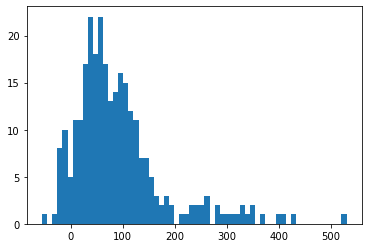

In [33]:
fig, axs = plt.subplots()
axs.hist(stress_t, bins=60)
fig.show()

In [34]:

T_set[0].info['dft_virial']

array([[  8.44017363,  -2.36454054,   1.78758717],
       [ -2.36454054,  13.34803232,   1.68922878],
       [  1.78758717,   1.68922878, -13.14022519]])

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Ge_calculation import GAP


data_dir = '/Users/Moji/Documents/Summer20/Ge/'
train_file = data_dir + 'Structure_databases/train_216_125_64_v.xyz'
val_file = data_dir + 'Structure_databases/validate_216_125_64_v.xyz'
pickle_file = data_dir + 'Pickles/data_125_216_d155'
pot = data_dir + 'Potentials/Ge_2bSOAP_5000_125_216_d155/Ge_2bSOAP_5000_125_216_d155.xml'

In [12]:
d155 = GAP(train_file, val_file, pot)

['/Users/Moji/PycharmProjects/Ge_analysis_local', '/Users/Moji/PycharmProjects/Ge_analysis_local', '/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python38.zip', '/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8', '/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8/lib-dynload', '', '/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8/site-packages', '/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8/site-packages/matscipy-0.4.0+32.g356b21e-py3.8-macosx-10.9-x86_64.egg', '/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8/site-packages/IPython/extensions', '/Users/Moji/.ipython', '/Users/Moji/Applications/QUIP/build/darwin_x86_64_gfortran', '/Users/Moji/Applications/QUIP/build/darwin_x86_64_gfortran']
Training set structure count: 281
Validation set structure count: 70
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']


In [ ]:
d155.calc_all()

In [14]:
d155.data_dict.values()

[[array([[  8.44017363,  -2.36454054,   1.78758717],
         [ -2.36454054,  13.34803232,   1.68922878],
         [  1.78758717,   1.68922878, -13.14022519]]),
  array([[29.07184945, -6.04329612, -9.57516878],
         [-6.04329612, 25.30028723,  1.45562981],
         [-9.57516878,  1.45562981, 30.61018632]]),
  array([[20.16073113, -5.39587248,  4.97229717],
         [-5.39587248, 18.28576197,  3.06445039],
         [ 4.97229717,  3.06445039, 28.78994813]]),
  array([[ 40.85653223,   1.46053428, -19.52911428],
         [  1.46053428,  19.34496289,  -3.73092843],
         [-19.52911428,  -3.73092843,  18.26133651]]),
  array([[ 8.26882438,  2.19011265,  4.01078062],
         [ 2.19011265,  5.34517705, -1.37407795],
         [ 4.01078062, -1.37407795,  4.5463721 ]]),
  array([[ 10.23532883,   6.17464576,  -8.40147534],
         [  6.17464576,  -5.00045283,  -3.79014935],
         [ -8.40147534,  -3.79014935, -22.94898431]]),
  array([[-12.48700485,  -2.97907997,  -1.0607607 ],
        

In [13]:
d155.T_configs[0][0].info['dft_virial']

array([[  8.44017363,  -2.36454054,   1.78758717],
       [ -2.36454054,  13.34803232,   1.68922878],
       [  1.78758717,   1.68922878, -13.14022519]])